In [1]:
library(tfdatasets)
library(keras)
library(tidyverse)
library(neuralnet)
library(mltools)
library(data.table)
library(caret)
library(dplyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘neuralnet’


The following object is masked from ‘package:dplyr’:

    compute



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




In [2]:
data_file_path = "../input/chocolate-bar-ratings/flavors_of_cacao.csv"

In [3]:
chocodata <- read.csv(data_file_path)

In [4]:
# some of our column names have spaces in them. This line changes the column names to 
# versions without spaces, which lets us talk about the columns by their names.
names(chocodata) <- make.names(names(chocodata), unique=TRUE)
# turn the percentages into numbers
chocodata$Cocoa.Percent <- sapply(chocodata$Cocoa.Percent, function(x) gsub("%", "", x))
# convert all the stuff that can be converted (like "75" for the percentages) into numeric types (like 75 the integer)
chocodata <- type_convert(chocodata)
# get rid of that useless, half-empty column
chocodata <- subset(chocodata, select = -Bean.Type)


── Column specification ────────────────────────────────────────────────────────
cols(
  Cocoa.Percent = col_double()
)




In [5]:
# We want to be able to turn the string elements to numeric encodings, 
# and for that we must get rid of the spaces and parentheses in the names
chocodata$Company...Maker.if.known. <- make.names(chocodata$Company...Maker.if.known.)
chocodata$Specific.Bean.Origin.or.Bar.Name <- make.names(chocodata$Specific.Bean.Origin.or.Bar.Name)
chocodata$Company.Location <- make.names(chocodata$Company.Location)
chocodata$Broad.Bean.Origin <- make.names(chocodata$Broad.Bean.Origin)
#head(chocodata, 50) # to see what that did to the dataset

# Version package neuralnet

Ignorez cette partie, le package neuralnet est éclaté c'est dit

In [6]:
#model <- neuralnet(Rating ~ Review.Date + Cocoa.Percent, train_dataset, hidden=c(3, 3), lifesign="full", rep=10)

In [7]:
#plot(model, rep="best")

# Version Keras

In [8]:
# on crée les tokenizers qui vont transformer les noms en entiers
tok_Company <- text_tokenizer(lower=FALSE, filter="")
tok_BeanOrig <- text_tokenizer(lower=FALSE, filter="")
tok_CompanyLoc <- text_tokenizer(lower=FALSE, filter="")
tok_BroadBean <- text_tokenizer(lower=FALSE, filter="")

In [9]:
# on fait apprendre aux tokenizers le vocabulaire nécessaire pour chaque colonne
fit_text_tokenizer(tok_Company, chocodata$Company...Maker.if.known.)
fit_text_tokenizer(tok_BeanOrig, chocodata$Specific.Bean.Origin.or.Bar.Name)
fit_text_tokenizer(tok_CompanyLoc, chocodata$Company.Location)
fit_text_tokenizer(tok_BroadBean, chocodata$Broad.Bean.Origin)

In [10]:
# transforme les strings en listes d'entiers, mais chaque liste est de taille 1
# parce qu'on a pris le soin de transformer "fuck bdr" en "fuck.bdr" ce qui fait 1 mot
chocodata$Company...Maker.if.known. <- texts_to_sequences(tok_Company, chocodata$Company...Maker.if.known.)
chocodata$Specific.Bean.Origin.or.Bar.Name <- texts_to_sequences(tok_BeanOrig, chocodata$Specific.Bean.Origin.or.Bar.Name)
chocodata$Company.Location <- texts_to_sequences(tok_CompanyLoc, chocodata$Company.Location)
chocodata$Broad.Bean.Origin <- texts_to_sequences(tok_BroadBean, chocodata$Broad.Bean.Origin)

In [11]:
# du coup on transforme les listes de taille 1 en entiers
chocodata$Company...Maker.if.known. <- unlist(chocodata$Company...Maker.if.known.)
chocodata$Specific.Bean.Origin.or.Bar.Name <- unlist(chocodata$Specific.Bean.Origin.or.Bar.Name)
chocodata$Company.Location <- unlist(chocodata$Company.Location)
chocodata$Broad.Bean.Origin <- unlist(chocodata$Broad.Bean.Origin)
head(chocodata)

,Company...Maker.if.known.,Specific.Bean.Origin.or.Bar.Name,REF,Review.Date,Cocoa.Percent,Company.Location,Rating,Broad.Bean.Origin
,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>
1,5,183,1876,2016,63,2,3.75,27
2,5,184,1676,2015,70,2,2.75,44
3,5,185,1676,2015,70,2,3.00,44
4,5,186,1680,2015,70,2,3.50,44
5,5,187,1704,2015,70,2,3.50,3
6,5,188,1315,2014,70,2,2.75,1


In [12]:
# on mélange les rows
set.seed(506)
shuffled_rows_indices <- sample(nrow(chocodata))
chocodata <- chocodata[shuffled_rows_indices, ]

In [13]:
# features et target
X = chocodata[ , c("Company...Maker.if.known.", "Specific.Bean.Origin.or.Bar.Name", 
                   "REF", "Review.Date", "Cocoa.Percent", 
                   "Company.Location", "Broad.Bean.Origin")]
Y = chocodata[ , c("Rating")]

In [14]:
# train/test sets
splitter <- sample(c(rep(0, 0.7 * nrow(chocodata)), rep(1, 0.3 * nrow(chocodata))))
x_train <- X[splitter == 0, ]   
x_test <- X[splitter == 1, ]
y_train <- Y[splitter ==0]
y_test <- Y[splitter ==1]

In [15]:
# on définit l'architecture du modèle
model <- keras_model_sequential()
model %>%
    layer_batch_normalization(input_shape=c(7)) %>%
    layer_dense(units = 20, activation = 'relu') %>%
    layer_dense(units = 10, activation = 'relu') %>%
    layer_dense(units = 1)

In [16]:
# on définit les paramètres d'entrainement du modèle
model %>% compile(
  optimizer = "sgd", 
  loss = "mean_squared_error"
)

# ça je m'en sers pas parce que ça casse le plot final mais ça peut servir un jour
# early_stop = callback_early_stopping(patience=30)

In [17]:
# convertit les data frames en tensors pour que le modèle puisse les lire
# TODO: trouver une meilleure façon de faire, je ne suis pas sûr que ça marche bien ça
x_traine <- k_constant(x_train)
y_traine <- k_constant(y_train)
x_teste <- k_constant(x_test)
y_teste <- k_constant(y_test)

In [18]:
# training
history <- fit(model, x_traine, y_traine, epochs = 30, verbose = 2, validation_data = c(x_teste, y_teste))

`geom_smooth()` using formula 'y ~ x'



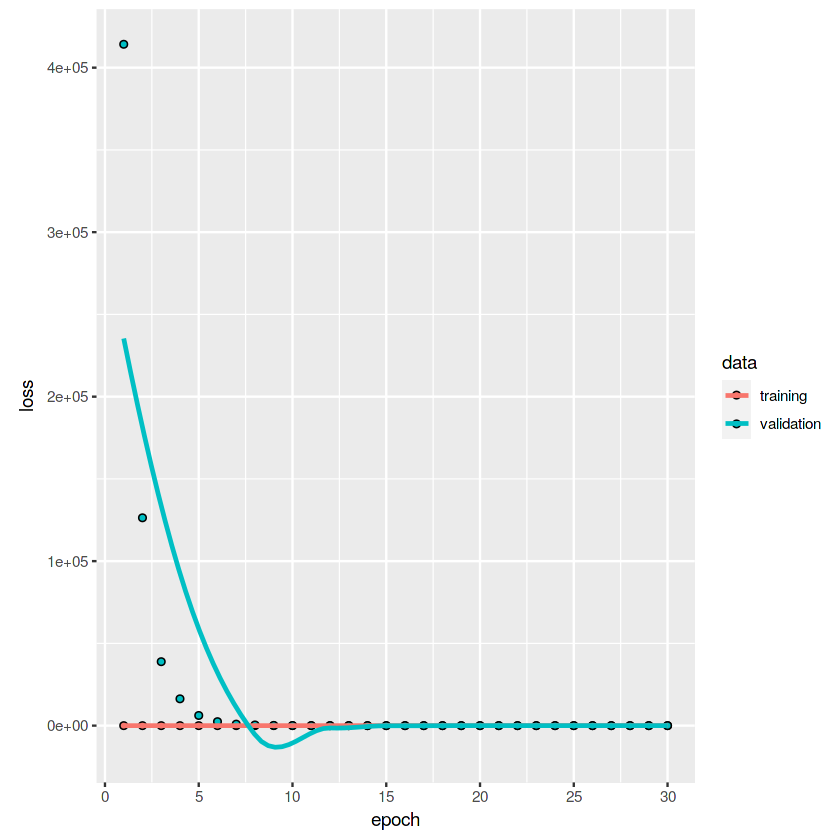

In [19]:
# bon alors y'a un truc chelou, la loss est à 0 mais l'accuracy est éclatée...
# y'a un problème à régler quelque part
plot(history)

In [20]:
# function to categorise
getPerformance <- function(g1, g2, g3)
{
  average <- (g1 + g2 + g3)/3  
 
  perf <- sapply(average, function(x)
  {
    if (x < 3)
    {
      "Poor";
    }
    else if(x >= 3 & x < 4)
    {
      "Good";
    }
    else
    {
      "Excellent";
    }
    
  })
 
  return (perf)
}

chocodata <- mutate(chocodata, performance = getPerformance(chocodata$G1, chocodata$G2, chocodata$G3))
chocodata <- select(chocodata, 'rating', 'cocoa.percent', 'broad.bean.origin', 'performance')
chocodata$performance <- as.factor(chocodata$performance)
chocodata$rating <- as.factor(chocodata$rating)
chocodata$cocoa.percent <- as.factor(chocodata$cocoa.percent)
chocodata$broad.bean.origin <- as.factor(chocodata$broad.bean.origin)

ERROR: Error: Problem with `mutate()` input `performance`.
[31m✖[39m Input `performance` can't be recycled to size 1795.
[34mℹ[39m Input `performance` is `getPerformance(chocodata$G1, chocodata$G2, chocodata$G3)`.
[34mℹ[39m Input `performance` must be size 1795 or 1, not 0.


ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'performance' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. pa

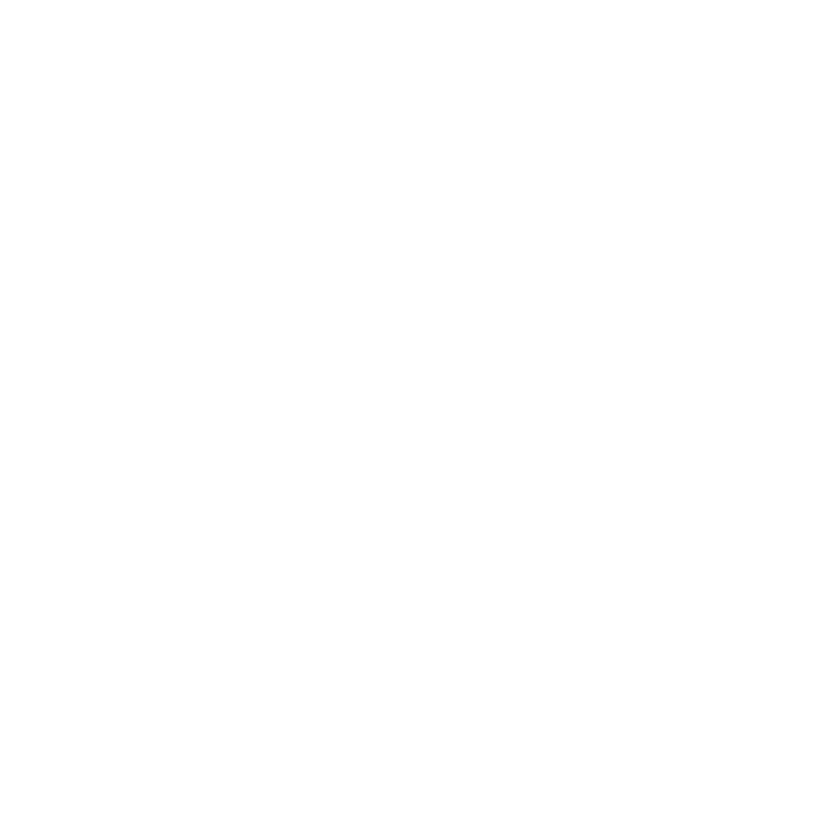

In [21]:
ggplot(data = chocodata, mapping = aes(x = performance, y = cocoa.percent)) + geom_boxplot()
ggplot(data = chocodata, mapping = aes(x = performance, y = broad.bean.origin)) + geom_jitter(aes(colour = performance))